In [10]:
import numpy as np
from common.functions import *

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros((b))]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        # slice
        f = A[:, :H]      # forget 게이트: 이전 기억셀(h_prev)에서 얼마나 망각할까?
        f = sigmoid(f)

        g = A[:, H:2*H]   # 새로운 기억 셀 (추가하는게 목적이므로 탄젠트 활성화 함수를 쓸 것이다.)
        g = np.tanh(g)   #|
                         #|
        i = A[:, 2*H:3*H] # 새로운 기억 셀에서 새 정보를 얼마나 가치있게 받아들일건가 (취사 선택)
        i = sigmoid(i)

        c_next = f * c_prev + g * i   # 기억 셀

        o = A[: 3*H:]     # 다음 은닉 상태를 얼마나!
        o = sigmoid(o)

        """
        .$tanh(c_t)$의 각 원소에 대해 ‘그것이 다음 시간의 은닉 상태에 얼마나 중요한가’를 조정한다.
        한편, 이 게이트는 다음 은닉 상태 $h_t$의 출력을 담당하는 게이트이므로 output 게이트(출력 게이트)라고 한다.
        """
        h_next = o * np.tanh(c_next)  # 컨텍스트

        self.cache = (x, h_prev, c_prev, i, f, g, o , c_next)
        return h_next, c_next

In [11]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

In [12]:
import numpy as np
from common.time_layers import *

In [19]:
class SimpleLSTMlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W  = (rn(V, D) / 100).astype('f')
        lstm_Wx  = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # Xavier 초깃값(이전 계층의 노드가 n개라면 표준편차가 1/sqrt(n))
        lstm_Wh  = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # Xavier 초깃값(이전 계층의 노드가 n개라면 표준편차가 1/sqrt(n))
        lstm_b   = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

말뭉치 크기: 1000, 어휘 수: 418
banknote, berlitz
| 에폭 1 | 퍼플렉서티 418.11
| 에폭 2 | 퍼플렉서티 417.40
| 에폭 3 | 퍼플렉서티 416.73
| 에폭 4 | 퍼플렉서티 416.03
| 에폭 5 | 퍼플렉서티 415.33
| 에폭 6 | 퍼플렉서티 414.46
| 에폭 7 | 퍼플렉서티 413.93
| 에폭 8 | 퍼플렉서티 413.38
| 에폭 9 | 퍼플렉서티 412.38
| 에폭 10 | 퍼플렉서티 412.12
| 에폭 11 | 퍼플렉서티 411.15
| 에폭 12 | 퍼플렉서티 410.40
| 에폭 13 | 퍼플렉서티 409.68
| 에폭 14 | 퍼플렉서티 409.34
| 에폭 15 | 퍼플렉서티 408.69
| 에폭 16 | 퍼플렉서티 407.23
| 에폭 17 | 퍼플렉서티 407.74
| 에폭 18 | 퍼플렉서티 406.47
| 에폭 19 | 퍼플렉서티 405.51
| 에폭 20 | 퍼플렉서티 405.06
| 에폭 21 | 퍼플렉서티 404.36
| 에폭 22 | 퍼플렉서티 404.13
| 에폭 23 | 퍼플렉서티 402.40
| 에폭 24 | 퍼플렉서티 402.93
| 에폭 25 | 퍼플렉서티 401.76
| 에폭 26 | 퍼플렉서티 400.44
| 에폭 27 | 퍼플렉서티 400.26
| 에폭 28 | 퍼플렉서티 400.20
| 에폭 29 | 퍼플렉서티 398.15
| 에폭 30 | 퍼플렉서티 398.41
| 에폭 31 | 퍼플렉서티 398.48
| 에폭 32 | 퍼플렉서티 396.03
| 에폭 33 | 퍼플렉서티 396.20
| 에폭 34 | 퍼플렉서티 396.02
| 에폭 35 | 퍼플렉서티 395.41
| 에폭 36 | 퍼플렉서티 393.20
| 에폭 37 | 퍼플렉서티 394.18
| 에폭 38 | 퍼플렉서티 393.57
| 에폭 39 | 퍼플렉서티 390.97
| 에폭 40 | 퍼플렉서티 392.65
| 에폭 41 | 퍼플렉서티 391.37
| 에폭 42 | 퍼플렉서티 389.89
|

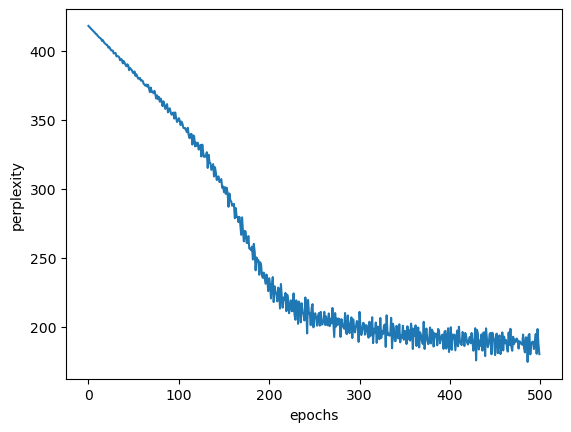

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # LSTM 은닉 상태 벡터의 원소 수
time_size = 35     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 500

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)) + 1

xs = corpus[:-1] # 입력
ts = corpus[1:]  # 출력(정답레이블)
data_size = len(xs)
print(f'말뭉치 크기: {corpus_size}, 어휘 수: {vocab_size}')
print(f'{id_to_word[xs[1]]}, {id_to_word[ts[1]]}')

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx   = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleLSTMlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ❶ 각 미니배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ❷ 미니배치 획득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # ❸ 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f' % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()